In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker,SafeMaskMaker
from gammapy.irf import EDispKernel
from gammapy.makers.utils import make_psf_map
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)
from gammapy.modeling import Fit

1.0


In [2]:
import os
os.chdir('../EventDataset/')
from EventDatasetMaker import EventDatasetMaker
from EventDataset import EventDataset

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up a binned and unbinned Dataset

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [67]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(0.5,100,40) # a fine binning in true energy
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.01,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [68]:
maker = MapDatasetMaker(selection=["counts", 'exposure','edisp', 'background', 'psf'])
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg')

reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model

In [69]:
test_maker = EventDatasetMaker(safe_mask_maker=maker_safe_mask, selection=None)
test_eds = test_maker.run(reference, obs1)
test_eds.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
bkg_model2 = FoVBackgroundModel(dataset_name=test_eds.name)
test_eds.models=bkg_model2

In [70]:
dataset.counts.data.sum(), dataset.counts.data[dataset.mask].sum()

(4881.0, 1090.0)

In [50]:
test_eds.event_mask, test_eds.event_mask.sum(), test_eds.event_mask.shape

(array([False,  True, False, ..., False, False, False]), 1091, (7613,))

## Test model evaluation

In [84]:
model_gauss = SkyModel(
#     spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spatial_model=PointSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg",  frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )
model_gauss.spatial_model.parameters.freeze_all()
dataset.models = [bkg_model,model_gauss]
test_eds.models = [bkg_model2,model_gauss.copy(name="crab_model_gauss")]

In [85]:
print(test_eds.models)

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : 4_V89tZb-bkg
  Datasets names            : ['4_V89tZb']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      0.941   +/-    0.03             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         

Component 1: SkyModel

  Name                      : crab_model_gauss
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.50e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      1.800   +/-    0.00             
    beta                          :      0.400   +/-    0.00             
    lon_0                 (frozen):    184.55

In [106]:
test_eds.evaluators['crab_model_gauss'].spatialbs = 0.01/2*u.deg
test_eds.evaluators['crab_model_gauss'].exposure = None

In [87]:
np.max(geom.pixel_scales).deg

0.01

In [107]:
test_eds.stat_sum()

-23056.189438242563

In [89]:
dataset.stat_sum()

16939.18941552972

In [90]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
print(result)
result.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 97
	total stat : 16939.12

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 8.67 s, sys: 7.48 ms, total: 8.68 s
Wall time: 8.69 s


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,9.3810e-01,,3.109e-02,nan,nan,False,True,
spectral,amplitude,3.3450e-11,cm-2 s-1 TeV-1,7.896e-12,nan,nan,False,True,
spectral,alpha,1.7091e+00,,4.638e-01,nan,nan,False,False,
spectral,beta,4.2041e-01,,1.988e-01,nan,nan,False,False,


In [109]:
%%time
result2 = fit.run([test_eds])
print(result2)
result2.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 99
	total stat : -23056.32

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 735 ms, sys: 2.8 ms, total: 738 ms
Wall time: 741 ms


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,9.4820e-01,,3.104e-02,nan,nan,False,True,
spectral,amplitude,3.4437e-11,cm-2 s-1 TeV-1,7.386e-12,nan,nan,False,True,
spectral,alpha,1.9472e+00,,4.061e-01,nan,nan,False,False,
spectral,beta,3.4654e-01,,1.756e-01,nan,nan,False,False,


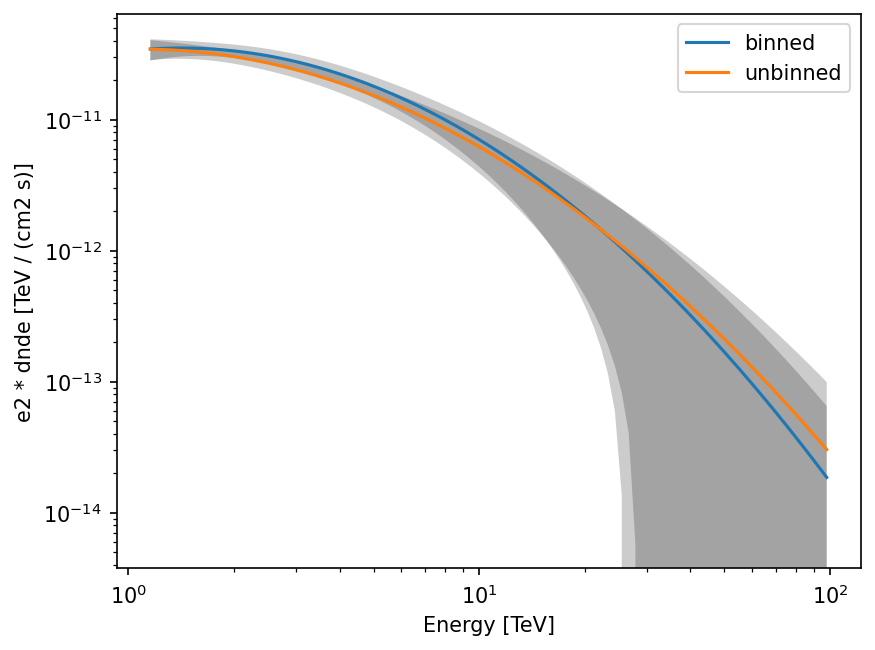

In [110]:
plt.figure(dpi=150)
dataset.models["crab_model_gauss"].spectral_model.plot(dataset.energy_range_total, energy_power=2, label="binned")
dataset.models["crab_model_gauss"].spectral_model.plot_error(dataset.energy_range_total, energy_power=2)
test_eds.models["crab_model_gauss"].spectral_model.plot(dataset.energy_range_total, energy_power=2, label="unbinned")
test_eds.models["crab_model_gauss"].spectral_model.plot_error(dataset.energy_range_total, energy_power=2)
plt.legend()

In [108]:
test_eds.evaluators['crab_model_gauss'].exposure.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (20, 20, 39)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 0.1 deg x 0.1 deg
	wcs ref    : 83.6 deg, 21.5 deg

In [94]:
dataset.evaluators['crab_model_gauss'].exposure.geom.pixel_scales.max().deg

0.01

In [39]:
profiles_bin = {}
profiles_unb = {}
for name in dataset.models.parameters.free_parameters.names:
    profiles_bin[name] = fit.stat_profile(dataset,name, reoptimize=True)
    profiles_unb[name] = fit.stat_profile(test_eds,name, reoptimize=True)

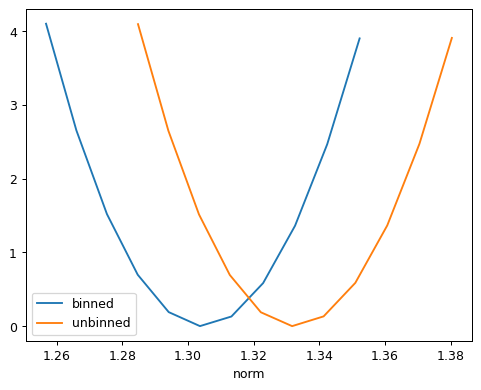

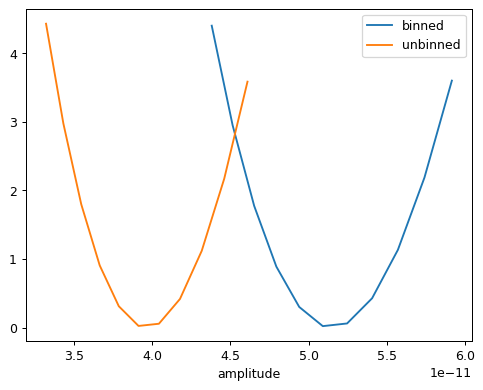

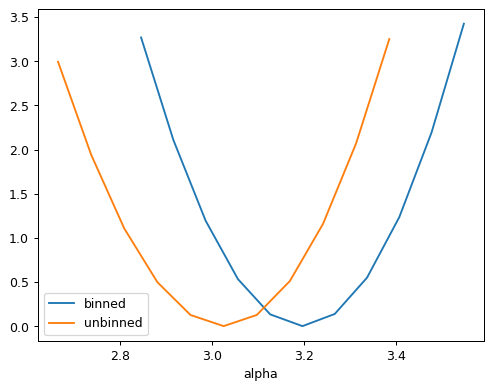

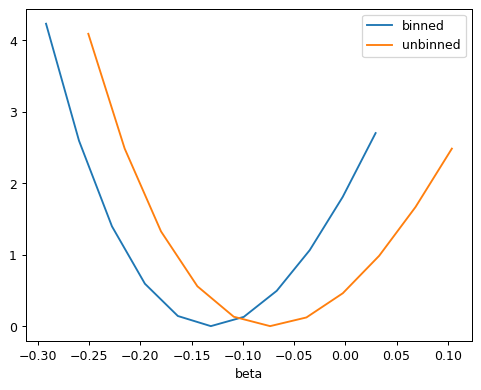

In [40]:
for name in dataset.models.parameters.free_parameters.names:
    plt.figure(dpi=90)
    xb,yb,_ = profiles_bin[name].values()
    xu,yu,_ = profiles_unb[name].values()
    plt.plot(xb, yb-result.total_stat, label='binned')
    plt.plot(xu, yu-result2.total_stat, label='unbinned')
    plt.legend()
    plt.xlabel(name)
    plt.show()

## Conclusion
### The spatial bin size of the Unbinned Evaluator
For the small Gaussian the pixel size of 0.02° is too large. The upsampling of the MapEvaluator doesn't work right so it keeps the 0.02° for model integration.  
If the Unbinned Evaluator also uses the 0.02° model integraion pixel size the fitted spectra agree very well and the fitting time is slightly faster.  
If the Unbinned Evaluator uses the fine pixel size of < 0.005° the fitted model is below the binned one meaning that more model flux is computed for the same amplitute. The cpu time for the fit increases slightly.  


For the PSF factors we do not use any oversampling of the map which means that for larger binsizes (0.02deg) there are differences in the fitted amplitude and shape of the model. The `get_psf_kernel` uses an oversampling of 4 by default which we also should implement in the future 